# One-dimensional Nanowire
I will use this notebook to study transport in a one-dimensional nanowire connected to contacts kept at a finite bias.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.optimize

## Device Hamiltonian
The first step is to define a Hamiltonian for the conductor region which will be coupled to two contacts. I will use a tight-binding Hamiltonian with a position dependent potential.

In [4]:
def V(x):
    '''
    Potential function inside the conductor region.
    '''
    return 0.0

def create_Hamiltonian(params):
    '''
    Return a matrix representation of Hamiltonian in the position basis.
    '''
    # number of device points
    N_d = params['N_d']
    t = params['t']
   
    # matrix element of the Hamiltonain in the position basis
    def matrix_element(x,y):
        if x == y:
            return V(x) + 2*t
        elif x == y + 1: 
            return -t
        elif x == y - 1:
            return np.conj(-t)
        else:
            return 0.0
        
    basis = np.arange(N_d)
    H = np.array([matrix_element(x,y) for x in basis for y in basis]).reshape(len(basis),len(basis))
    
    return H

In [110]:
params = {
    'N_d' : 4,
    't' : 1.0,
}

H = create_Hamiltonian(params)
print(H)

[[ 2. -1.  0.  0.]
 [-1.  2. -1.  0.]
 [ 0. -1.  2. -1.]
 [ 0.  0. -1.  2.]]


## Density of States
The next step is to find a density of states as a function of energy in the Hamiltonian.

In [111]:
def dos(E,H,eta = 1e-8):
    '''
    Returns the density of states for the Hamiltonian H at energy E
    eta is the parameter used in the Green's function calculation, ideally it should be set to a fraction of the
    grid spacing in the E_vec over which the dos is being calculated.
    '''
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H.shape[0]).reshape(1,H.shape[0],H.shape[1]) - H)
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1)))
    # casting to real done to avoid problems later with plotting
    a = np.real(np.trace(A,axis1=-1,axis2=-2))
    return a

In [112]:
E_vec = np.linspace(0,4,10000)
eta = (E_vec[1] - E_vec[0])
dos_vec = dos(E_vec,H,eta)

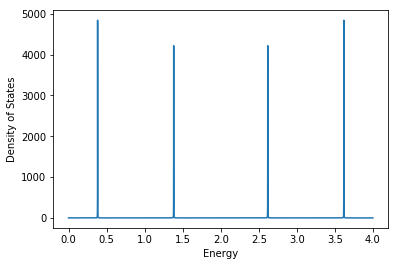

In [113]:
plt.plot(E_vec,dos_vec)
plt.xlabel('Energy')
plt.ylabel('Density of States')

# Contact Self-Energy
In order to include the effect of the contacts, they are handled by introduction of a self-energy in the Green's function calculation.

### Calculation of the surface Green's function
Self-Energy calculation will proceed in two steps. First the surface Green's function for each contact is calculated.

In [114]:
def calc_surface_g(E,params,eta = 1e-8,eps = 1e-4,N_lim = 10000):
    '''
    Return the surface Green's function at energy E for a one-dimensional nanowire
    eta is used to calculated the Green's function
    eps controls the acurray to which the surface Green's function is calculated.
    N_lim is the limit on number of iterations, else it raises an Exception
    '''
    t = params['t']
    
    g = 0
    # intial error
    err = 1.0
    n_iter = 0
    while err > eps:
        g_new = 1.0/((E + 1j*eta) - 2*t - t*g*np.conj(t))
        g_new = 0.5*(g + g_new)
        err = np.abs(g - g_new)
        
        g = g_new
        n_iter += 1
        
        if(n_iter > N_lim):
            raise Exception("Convergence failed in surface_g calculation at E = " + str(E))
       
    return g

In [115]:
# alternate implementation of calc_surface_g
def calc_surface_g(E,params,eta = 1e-8,eps = 1e-4,N_lim = 10000):
    '''
    Return the surface Green's function at energy E for a one-dimensional nanowire
    eta is used to calculated the Green's function
    eps controls the acurray to which the surface Green's function is calculated.
    N_lim is the limit on number of iterations, else it raises an Exception
    '''
    t = params['t']
   
    def func(g,E,t,eta):
        return 1.0/((E + 1j*eta) - 2*t - t*g*np.conj(t))
   
    g = scipy.optimize.fixed_point(func,np.zeros(len(E)),args=(E,t,eta),xtol=eps)
    return g

In [116]:
# testing of the surface-g calculation
E_vec = np.linspace(0,4,1000)
eta = (E_vec[1] - E_vec[0])
g_vec = calc_surface_g(E_vec,params,eta)

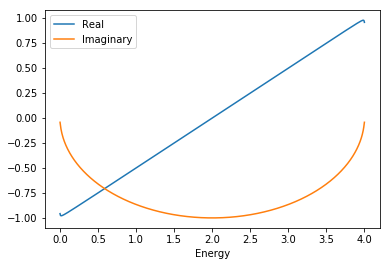

In [119]:
plt.plot(E_vec,np.real(g_vec),label="Real")
plt.plot(E_vec,np.imag(g_vec),label="Imaginary")
plt.xlabel('Energy')
plt.legend()